In [ ]:
# default_exp agglomerative_clustering

In [1]:
# export
from multiinstance.utils import *
from multiinstance.distanceApproaches import *
from multiinstance.data.syntheticData import buildDataset,getBag

import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity

import scipy.stats as ss

from tqdm.notebook import tqdm



In [25]:
from numba import set_num_threads

In [33]:
set_num_threads(10)

In [ ]:
# export
class AgglomerativeClustering:
    def __init__(self, dsi, kstest_alpha):
        self.clusterMembers = {i:[i] for i in range(dsi.N)}
        self.clusterAlphaHats = {i: dsi.alphaHats[i] for i in range(dsi.N)}
        self.ds = dsi
        self.log = []
        self.meanAbsErrs = []
        self.bagEstimateVariances = []
        self.kstest_alpha = kstest_alpha
        self.nummerges = 0

    def clusteringIteration(self):
        # track whether any new clusters are merged, indicating this new cluster might not have
        # been compared to other clusters and a new iteration is needed to do so
        nextIterNeeded=False
        clusters = list(self.clusterMembers.keys())
        np.random.shuffle(clusters)
        for ci in tqdm(clusters, leave=False, desc="clustering iteration"):
            # might have to skip iteration if this cluster was merged elsewhere in a previous for loop iter
            if ci in self.clusterMembers.keys():
                
                # merging candidates are other remaining clusters
                candidates = list(set(self.clusterMembers.keys()) - {ci})
                np.random.shuffle(candidates)
                for cj in candidates:
                    # get current one-dimensional scores for all unlabeled instances in all bags in this cluster
                    scores_i = np.concatenate(tuple([getTransformScores(self.ds,b)[1] for b in self.clusterMembers[ci]]))
                    # get scores for merge candidate cluster
                    scores_j = np.concatenate([getTransformScores(self.ds,b)[1] for b in self.clusterMembers[cj]])
                    # 2-sided kolmogrov-smirnov test (H0: samples from same distribution)
                    stat,p = ss.ks_2samp(scores_i.tolist(),scores_j.tolist())
                    # if you fail to reject, merge samples
                    if p > self.kstest_alpha:
                        self.nummerges += 1
                        nextIterNeeded=True
                        # add this merge to the log
                        self.log.append((ci,cj, p))
                        # perform the actual merge
                        self.clusterMembers[ci] = self.clusterMembers[ci] + self.clusterMembers.pop(cj)
                        # track the within-bag class prior variance at each clustering iteration
                        self.doLogging()
        return nextIterNeeded
    
    def alphaclusteringIteration(self):
        # track whether any new clusters are merged, indicating this new cluster might not have
        # been compared to other clusters and a new iteration is needed to do so
        nextIterNeeded=False
        clusters = list(self.clusterMembers.keys())
        np.random.shuffle(clusters)
        for ci in tqdm(clusters, leave=False, desc="clustering iteration"):
            # might have to skip iteration if this cluster was merged elsewhere in a previous for loop iter
            if ci in self.clusterMembers.keys():
                
                # merging candidates are other remaining clusters
                candidates = list(set(self.clusterMembers.keys()) - {ci})
                np.random.shuffle(candidates)
                for cj in tqdm(candidates,total=len(candidateses),desc="candidates",leave=False):
                    # use the alpha hat estimates for each bag as the samples for the test
                    scores_i = self.clusterAlphaHats[ci]
                    scores_j = self.clusterAlphaHats[cj]
                    # 2-sided kolmogrov-smirnov test (H0: samples from same distribution)
                    stat,p = ss.ks_2samp(scores_i.tolist(),scores_j.tolist())
                    # if you fail to reject, merge samples
                    if p > self.kstest_alpha:
                        nextIterNeeded=True
                        # add this merge to the log
                        self.log.append((ci,cj, p))
                        # perform the actual merge
                        self.clusterMembers[ci] = self.clusterMembers[ci] + self.clusterMembers.pop(cj)
                        # track the within-bag class prior variance at each clustering iteration
                        self.doLogging()
        return nextIterNeeded
        
    def doLogging(self):
        absErrs = []
        bagEstVar = 0
        aes = 0
        
        for bagNum,bags in self.clusterMembers.items():
            # Get cluster estimate
            if len(bags) > 1:
                P,U = list(zip(*[self.ds.getBag(b) for b in bags]))
                p = np.concatenate(P)
                u = np.concatenate(U)
                alphaHats, _ = getEsts(p,u,10)
                clusterAlphaHat = np.mean(alphaHats)
                self.clusterAlphaHats[bagNum] = alphaHats
                clusterAlphas = self.ds.trueAlphas[bags].flatten()
            else:
                clusterAlphaHat = self.ds.alphaHats[bags].mean(1)
                clusterAlphas = self.ds.trueAlphas[bags].flatten()
            absErrs.append(np.abs(clusterAlphaHat - clusterAlphas))
            # Get the true and predicted alphas for each bag in this cluster
            bagsAlphaHat = self.ds.alphaHats[bags].reshape((len(bags),-1)).mean(1)
            # log abs. err for this cluster
            # add to calculation for variance in estimates for this cluster
            bagEstVar += np.sum((bagsAlphaHat - clusterAlphaHat)**2)
        self.meanAbsErrs.append(np.mean(np.concatenate(absErrs)))
        self.bagEstimateVariances.append(bagEstVar / (self.ds.N - 1))

    def cluster(self):
        self.doLogging()
        nextIterNeeded = self.clusteringIteration()
        while nextIterNeeded:
            nextIterNeeded = self.clusteringIteration()
                                       

In [27]:
dsi = buildDataset(100,alphaDistr=lambda: np.random.uniform(.01,.25),
                      nP=5,nU=15)

dsi = addTransformScores(dsi)

dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=10)

In [28]:
agg0 = AgglomerativeClustering(dsi, .75)


In [29]:
agg0.cluster()

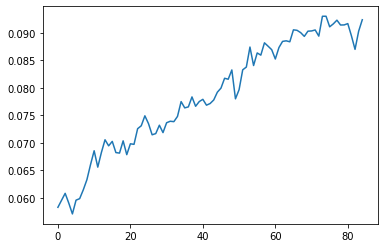

In [30]:
plt.plot(agg0.meanAbsErrs)

In [31]:
def exp():
    dsi = buildDataset(100,alphaDistr=lambda: np.random.uniform(.01,.25),
                      nP=5,nU=10)

    dsi = addTransformScores(dsi)

    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=10)
    alphas = [0.5, 0.65, 0.75,0.85, 0.95]
    aggs = []
    for alpha in tqdm(alphas,desc="alphas"):
        print("alpha = {}".format(alpha))
        agg0 = AgglomerativeClustering(dsi, alpha)
        agg0.cluster()
        aggs.append(agg0)
    return alphas, aggs

def makeFig(alphas, aggs):
    fig,ax = plt.subplots(1,len(aggs), figsize=(16,4),sharey=True)
    for r in range(len(aggs)):
        ax[r].plot(aggs[r].meanAbsErrs, label=r"\alpha = "+str(alphas[r]))
        ax[r].set_title(r"$\alpha$: "+str(alphas[r]))
    return fig

alpha = 0.5


alpha = 0.65


alpha = 0.75


alpha = 0.85


alpha = 0.95


alpha = 0.5


alpha = 0.65


alpha = 0.75


alpha = 0.85


alpha = 0.95


alpha = 0.5


alpha = 0.65


KeyboardInterrupt: 

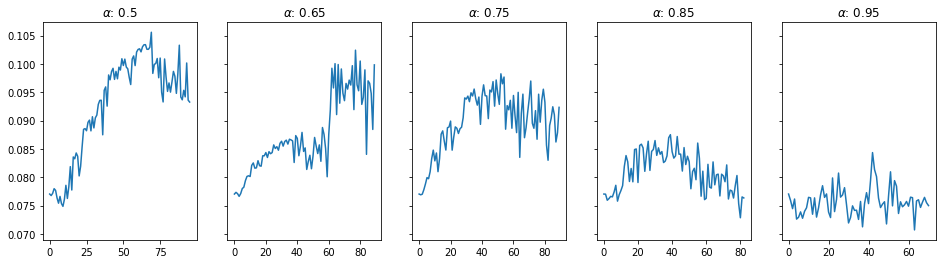

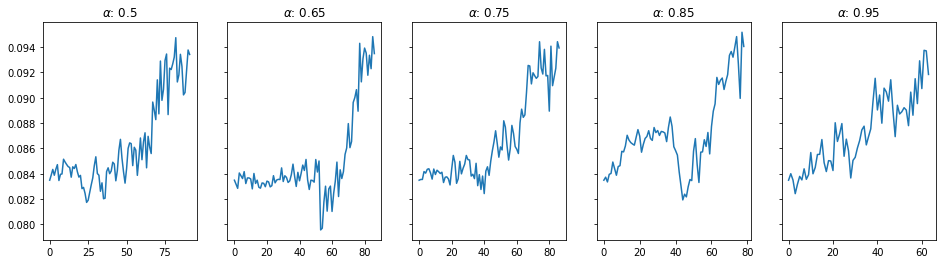

In [34]:
for rep in tqdm(range(10)):
    alphas2, aggs2 = exp()

    fig = makeFig(alphas2, aggs2)
    plt.savefig("figs/nb_06/fig_{}.pdf".format(rep),
                format="pdf")

* want many clusters with small $\alpha$ variance
* don't want to merge a bag large enough to have low variance in estimations
* two ways of estimating cluster similarity
    * similarity in transform scores
        * KS-test has critical value hyperparameter
        * wasserstein distance has distance cutoff hyperparameter
    * similarity in estimates from distcurve
        * 